In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sts
import plotly.graph_objects as go
import plotly.express as exp
import seaborn as sns
import talib as ta

In [2]:
data = pd.read_csv("../Data/train.csv")
t = pd.read_csv("../Data/test.csv")
ev = pd.read_csv("../Data/eval.csv")

In [3]:
data = pd.concat([data, t, ev])

In [4]:
data.head()

,Unnamed: 0,Datetime,Open,High,Low,Close,Adj Close,Volume
0,0,2021-08-02 00:00:00,1.187085,1.187225,1.186521,1.186944,1.186944,0
1,1,2021-08-02 01:00:00,1.186944,1.187790,1.186662,1.187225,1.187225,0
2,2,2021-08-02 02:00:00,1.187507,1.187507,1.186521,1.186803,1.186803,0
3,3,2021-08-02 03:00:00,1.187085,1.187507,1.186240,1.187507,1.187507,0
4,4,2021-08-02 04:00:00,1.187790,1.187931,1.187366,1.187507,1.187507,0


In [5]:
data = data.drop(columns=["Unnamed: 0"])
data.set_index(pd.to_datetime(data["Datetime"]), inplace=True)

In [6]:
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2021-08-02 00:00:00,2021-08-02 00:00:00,1.187085,1.187225,1.186521,1.186944,1.186944,0
2021-08-02 01:00:00,2021-08-02 01:00:00,1.186944,1.187790,1.186662,1.187225,1.187225,0
2021-08-02 02:00:00,2021-08-02 02:00:00,1.187507,1.187507,1.186521,1.186803,1.186803,0
2021-08-02 03:00:00,2021-08-02 03:00:00,1.187085,1.187507,1.186240,1.187507,1.187507,0
2021-08-02 04:00:00,2021-08-02 04:00:00,1.187790,1.187931,1.187366,1.187507,1.187507,0


In [25]:
data.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
data["O"] = data["Open"].shift(1)
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,O
Datetime,,,,,,,,
2021-08-02 00:00:00,2021-08-02 00:00:00,1.187085,1.187225,1.186521,1.186944,1.186944,0,NaN
2021-08-02 01:00:00,2021-08-02 01:00:00,1.186944,1.187790,1.186662,1.187225,1.187225,0,1.187085
2021-08-02 02:00:00,2021-08-02 02:00:00,1.187507,1.187507,1.186521,1.186803,1.186803,0,1.186944
2021-08-02 03:00:00,2021-08-02 03:00:00,1.187085,1.187507,1.186240,1.187507,1.187507,0,1.187507
2021-08-02 04:00:00,2021-08-02 04:00:00,1.187790,1.187931,1.187366,1.187507,1.187507,0,1.187085


In [ ]:
def appliquer(x):
    

In [25]:
def features(data, i, j, k):
    """ 
        data: the dataset
        i: the periode where to calculate the high
        j: the step where to calculate the max
        k: the periode where to calculate de minimum value
    """
    data_ = data.copy()
    data_["Open_"] = data_["Open"].shift(1)
    data_["Low_"] = data_["Low"].shift(1)
    data_["Low__"] = data_["Low"].shift(-1)
    data_["Open__"] = data_["Open"].shift(-1)
    data_["Close_"] = data_["Close"].shift(1)
    data_["Close__"] = data_["Close"].shift(-1)
    data_["Var"] = data_["Open"] - data_["Close"]

    data_["Trend_"] = np.where(data_["Open_"] > data_["Close_"], -1, 1)
    data_["Trend"] = np.where(data_["Open"] > data_["Close"], -1, 1)
    data_["Count"] = data_["Trend"].rolling(k).sum().shift(1)
    data_["Mean"] = data_["High"].rolling(3).mean().shift(1)
    data_["tp1"] = data_["High"].rolling(i).max().shift(1)
    data_["Strengh"] = data_["Var"].rolling(8).sum().shift(1)

    data_["Argmax"] = data_["High"].rolling(i).apply(lambda x: x.argmax() if not x.empty else None).shift(1)
    data_["Argmin"] = data_["Low"].rolling(i).apply(lambda x: x.argmin() if not x.empty else None).shift(1)
    data_["Max_3"] = data_["High"].rolling(j).max().shift(-j)
    data_["Min_3"] = data_["Low"].rolling(j).min().shift(-j)
    data_["T"] = np.where(data_["tp1"]<data_["Open__"],-1, 1)
    
    data_["Verif"] = np.where(((data_["Trend_"] == -1) & (data_["Trend"] == 1) & (data_["T"] == 1) & (data_["Strengh"]> 0.00125) & (data_["Close"] > data_["Open_"]) & (data_["Open"]<= data_["Close_"])), 1, -1)
    data_["sl"] = data_["Low"].rolling(j).min().shift(1)
    data_["sl1"] = data_["Open__"] - data_["sl"]
    data_["G1"] = np.where(((data_["tp1"] <= data_["Max_3"]) & (data_["sl"]<data_["Min_3"])),1, -1)

    return data_

In [93]:
I = np.random.randint(9, 24, 5)
J = np.random.randint(2, 24, 5)

In [26]:
dataset = features(data, 12, 24, 12)
dataset = dataset[dataset.Verif == 1]


In [47]:
dataset.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Open_,Low_,Low__,...,tp1,Argmax,Argmin,Max_3,Min_3,T,Verif,sl,sl1,G1
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-16 15:00:00,2021-08-16 15:00:00,1.177718,1.179663,1.177718,1.179523,1.179523,0,1.178134,1.177718,1.177995,...,1.180638,0.0,9.0,1.179245,1.171783,1,1,1.176747,0.002359,0
2021-08-17 08:00:00,2021-08-17 08:00:00,1.176471,1.177718,1.176471,1.177579,1.177579,0,1.177302,1.176471,1.177302,...,1.178689,3.0,11.0,1.178828,1.170549,1,1,1.176471,0.001108,0
2021-08-17 18:00:00,2021-08-17 18:00:00,1.171372,1.172470,1.171372,1.172058,1.172058,0,1.171783,1.171372,1.171509,...,1.178828,3.0,10.0,1.173434,1.169864,1,1,1.171372,0.000824,0
2021-08-18 07:00:00,2021-08-18 07:00:00,1.171783,1.173020,1.171646,1.172333,1.172333,0,1.172196,1.171646,1.172058,...,1.172745,9.0,4.0,1.173847,1.166997,1,1,1.170549,0.001509,0
2021-08-19 07:00:00,2021-08-19 07:00:00,1.167679,1.168497,1.167270,1.168224,1.168224,0,1.168088,1.167406,1.167542,...,1.173847,0.0,9.0,1.170823,1.167270,1,1,1.166997,0.001364,0


In [23]:
dataset.groupby("G1").count()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Open_,Low_,Low__,...,tp1,Strengh,Argmax,Argmin,Max_3,Min_3,T,Verif,sl,sl1
G1,,,,,,,,,,,,,,,,,,,,,
-1,88,88,88,88,88,88,88,88,88,88,...,88,88,88,88,87,87,88,88,88,88
1,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32


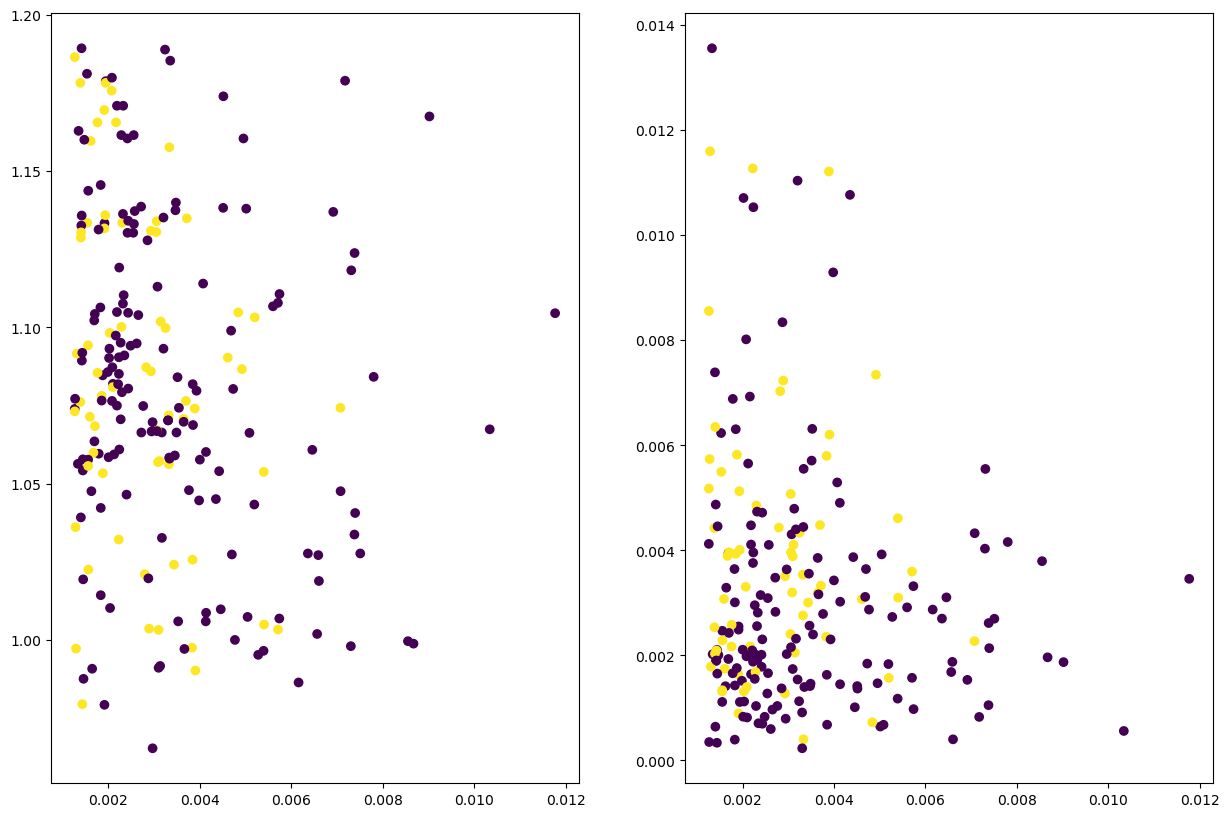

In [27]:
fig,axes = plt.subplots( figsize=(15, 10), nrows=1, ncols= 2)

axes[0].scatter(dataset["Strengh"], dataset["tp1"], c = dataset["G1"])
axes[1].scatter(dataset["Strengh"], dataset["sl1"], c = dataset["G1"])

In [20]:
0.005/2

0.0025

In [77]:
dataset.groupby("G").count()

,Open,High,Low,Close,Adj Close,Volume,Open_,Open__,Close_,Trend_,Trend,Close__,Max_3,Min_3,Verif,tp,sl
G,,,,,,,,,,,,,,,,,
0,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296
1,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337


In [104]:
import pandas as pd

# Création d'une série temporelle fictive
data = {'Timestamp': pd.date_range(start='2023-01-01', periods=10, freq='D'),
        'Value': [10, 15, 8, 20, 12, 18, 25, 9, 14, 22]}
df = pd.DataFrame(data)

# Spécification de la taille de la fenêtre glissante
window_size = 3

# Utilisation de la méthode rolling et argmax pour obtenir les positions des maxima locaux
df['Argmax_Position'] = df['Value'].rolling(window=window_size).apply(lambda x: x.argmin() if not x.empty else None)

# Affichage du DataFrame résultant
print(df)


   Timestamp  Value  Argmax_Position
0 2023-01-01     10              NaN
1 2023-01-02     15              NaN
2 2023-01-03      8              2.0
3 2023-01-04     20              1.0
4 2023-01-05     12              0.0
5 2023-01-06     18              1.0
6 2023-01-07     25              0.0
7 2023-01-08      9              2.0
8 2023-01-09     14              1.0
9 2023-01-10     22              0.0


In [14]:
import pandas as pd

# Créer une série de données
s = pd.Series([1, 2, 3, 4, 5])

# Définir une fonction personnalisée
def multiply_by_two(x):
    return x * 2

# Appliquer la fonction personnalisée à chaque élément de la série
s = s.apply(multiply_by_two)

print(s)


0     2
1     4
2     6
3     8
4    10
dtype: int64


In [5]:
import pandas as pd

# Créer un DataFrame de exemple
data = {'Nom': ['Alice', 'Bob', 'Charlie'],
        'Âge': [25, 30, 35],
        'Ville': ['Paris', 'New York', 'Los Angeles']}
df = pd.DataFrame(data)

# Définir une fonction personnalisée pour retourner l'indice de la ligne
def retourner_indice(row):
    return row.name

# Appliquer la fonction personnalisée aux lignes du DataFrame en utilisant apply avec axis=1
df['Indice'] = df.apply(retourner_indice, axis=1)

# Afficher le DataFrame résultant
print(df)


       Nom  Âge        Ville  Indice
0    Alice   25        Paris       0
1      Bob   30     New York       1
2  Charlie   35  Los Angeles       2


In [35]:
v = pd.DataFrame([1,4,-1, 2,12, 9,3,18, 23, -9, -10], columns=["A"])

In [43]:
v["max"] = v["A"].rolling(3).max().shift(1)
v

,A,max
0,1,NaN
1,4,NaN
2,-1,NaN
3,2,4.0
4,12,4.0
5,9,12.0
6,3,12.0
7,18,12.0
8,23,18.0
9,-9,23.0
